In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

2024-12-04 18:33:47.251931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 18:33:47.255441: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 18:33:47.322406: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 18:33:47.349788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733326427.404225   35678 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733326427.41

## price prediction model

In [2]:
df = pd.read_csv('datasets/Nickel Futures Historical Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988 entries, 0 to 2987
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         2988 non-null   object
 1   Price        2988 non-null   object
 2   Open         2988 non-null   object
 3   High         2988 non-null   object
 4   Low          2988 non-null   object
 5   Vol.         2988 non-null   object
 6   Change %     2988 non-null   object
dtypes: object(7)
memory usage: 163.5+ KB


In [4]:
df.columns = ["Date", "Price", "Open", "High", "Low", "Vol", "Change"]

In [5]:
df.drop(['Vol', 'Change'], axis=1, inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')/1000

In [8]:
df

,Date,Price,Open,High,Low
0,2013-01-14,17.325,17.5310,17.6520,17.258
1,2013-01-15,17.510,17.3000,17.5700,17.143
2,2013-01-16,17.405,17.5000,17.6220,17.329
3,2013-01-17,17.586,17.4100,17.5990,17.353
4,2013-01-18,17.560,17.6000,17.7200,17.491
...,...,...,...,...,...
2983,2024-11-08,16.327,16.4650,16.5330,16.324
2984,2024-11-11,16.083,16.1805,16.2785,16.076
2985,2024-11-12,15.989,16.0035,16.1030,15.879
2986,2024-11-13,15.765,15.9335,15.9400,15.723


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.isnull().sum().sum()

np.int64(0)

In [ ]:
df.Date

0      2013-01-14
1      2013-01-15
2      2013-01-16
3      2013-01-17
4      2013-01-18
          ...    
2983   2024-11-08
2984   2024-11-11
2985   2024-11-12
2986   2024-11-13
2987   2024-11-14
Name: Date, Length: 2988, dtype: datetime64[ns]

In [11]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Product Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [272]:
#test_size = df[df.Date.dt.year>=2022].shape[0]
test_size = int(df.shape[0]*0.2)
test_size

597

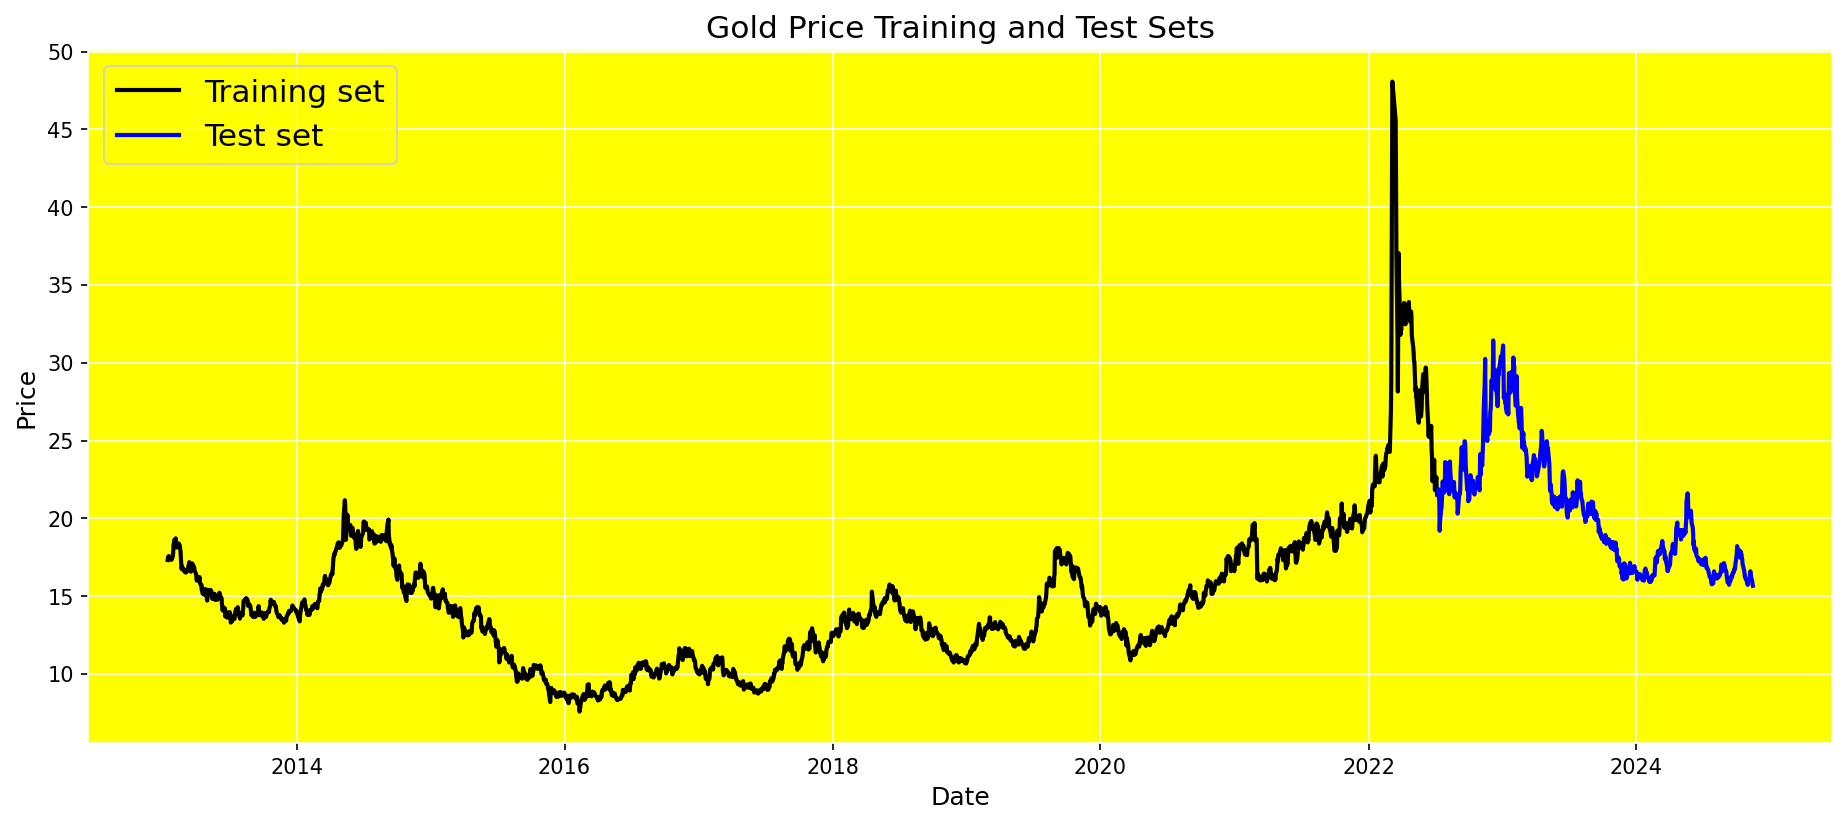

In [273]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [274]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [275]:
window_size = 30
interval_days = 3

In [276]:
df["Price"] = scaler.transform(df["Price"].to_numpy().reshape((df.shape[0], 1))).T[0]

In [277]:
df['Price_Avg_30'] = df['Price'].rolling(window=window_size).mean()
df['Price_Std_30'] = df['Price'].rolling(window=window_size).std()
df['Price_Lag_1'] = df['Price'].shift(-1)
df['Price_Lag_3'] = df['Price'].shift(-3)
df['Price_Lag_5'] = df['Price'].shift(-5)

# Target is 3-day average future price
df['Future_Price_Avg_3'] = df['Price'].shift(-interval_days).rolling(window=interval_days).mean()

In [278]:
df.dropna(inplace=True)

In [279]:
df.head(10)

,Date,Price,Open,High,Low,Price_Avg_30,Price_Std_30,Price_Lag_1,Price_Lag_3,Price_Lag_5,Future_Price_Avg_3
29,2013-02-22,0.230809,16.775,17.046,16.610,0.252865,0.013506,0.224783,0.225746,0.222930,0.225425
30,2013-02-25,0.224783,16.895,16.973,16.680,0.252343,0.014283,0.225746,0.222659,0.220806,0.224717
31,2013-02-26,0.225746,16.660,16.762,16.465,0.251701,0.015037,0.225746,0.222930,0.223548,0.223778
32,2013-02-27,0.225746,16.651,16.830,16.639,0.251145,0.015686,0.222659,0.220806,0.221300,0.222132
33,2013-02-28,0.222659,16.750,16.860,16.605,0.250338,0.016515,0.222930,0.223548,0.222165,0.222428
34,2013-03-01,0.222930,16.650,16.775,16.368,0.249560,0.017246,0.220806,0.221300,0.224289,0.221885
35,2013-03-04,0.220806,16.610,16.725,16.489,0.248843,0.017989,0.223548,0.222165,0.228339,0.222337
36,2013-03-05,0.223548,16.550,16.707,16.485,0.248157,0.018559,0.221300,0.224289,0.232489,0.222584
37,2013-03-06,0.221300,16.650,16.721,16.531,0.247365,0.019191,0.222165,0.228339,0.231427,0.224931
38,2013-03-07,0.222165,16.561,16.721,16.535,0.246744,0.019706,0.224289,0.232489,0.237132,0.228372


In [280]:
from sklearn.model_selection import train_test_split

features = ['Price_Avg_30', 'Price_Std_30', 'Price_Lag_1', 'Price_Lag_3',  'Price_Lag_5']
X = df[features]
y = df['Future_Price_Avg_3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [281]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predict interval average price
y_pred = model.predict(X_test)

In [282]:
from sklearn.metrics import mean_squared_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE
print("Test Loss:", mean_squared_error(y_test, y_pred))
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 1.3677071594578232e-05
Test MAPE: 0.00835351200050517
Test Accuracy: 0.9916464879994948


In [283]:
y_test_true = scaler.inverse_transform(y_test.to_numpy().reshape((y_test.shape[0], 1))).T[0]
y_test_pred = scaler.inverse_transform(y_pred.reshape(len(y_pred), 1)).T[0]

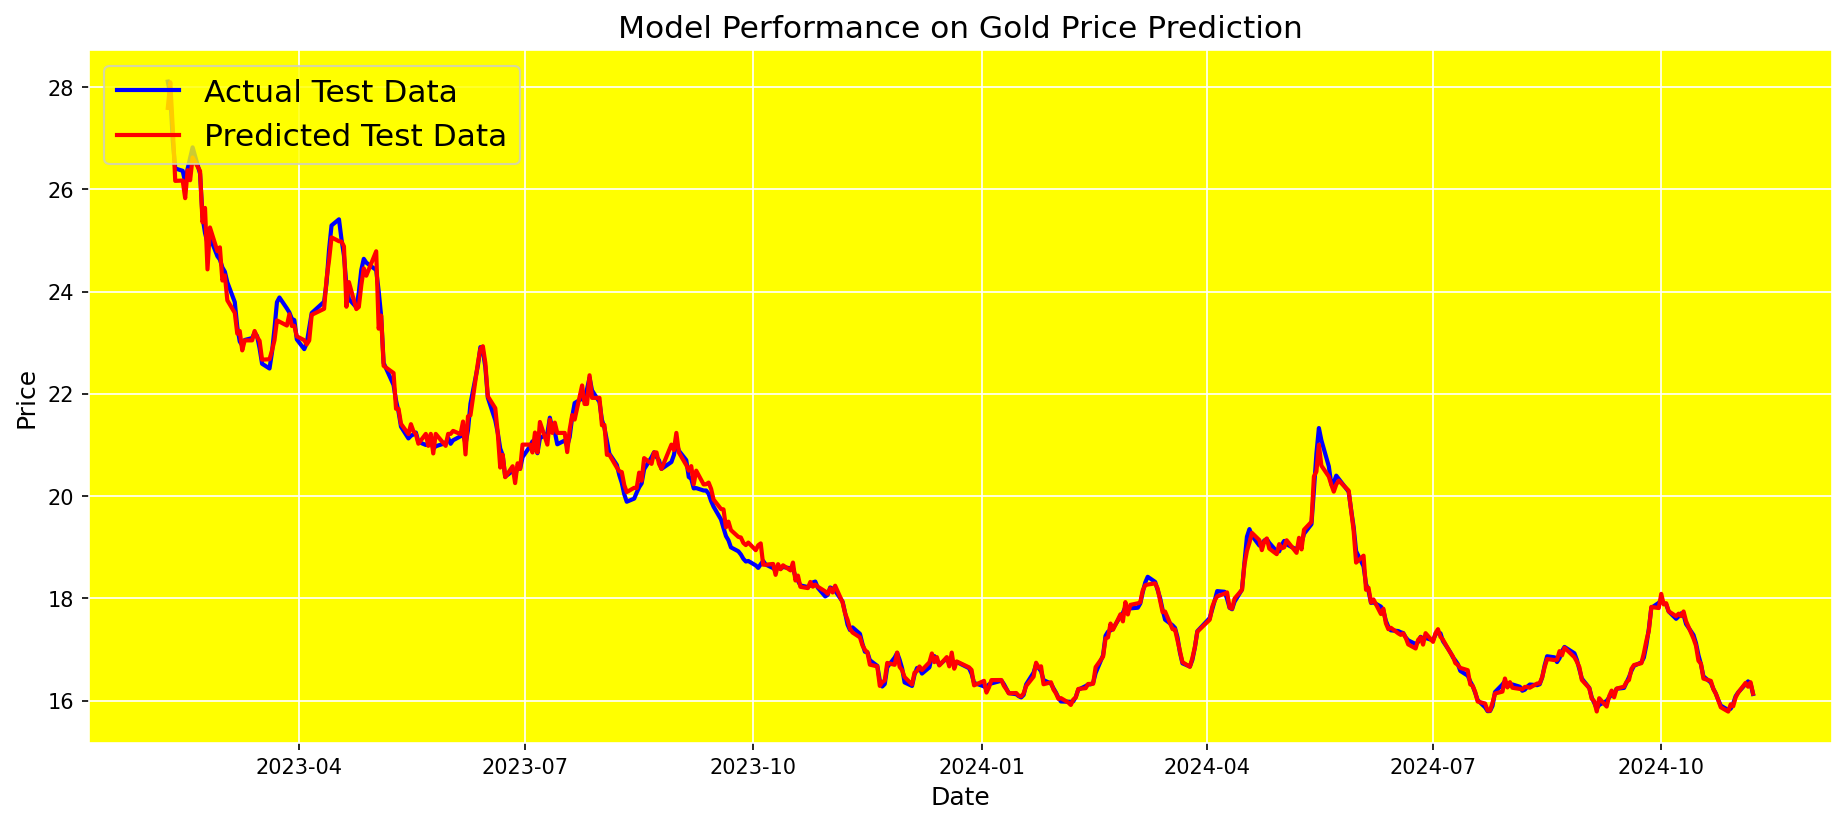

In [284]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-len(y_pred):], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-len(y_pred):], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [285]:
import joblib

# Сохранение модели в файл
joblib.dump(model, 'xgboost_model_predict_product_price_3d.joblib')

['xgboost_model_predict_product_price_3d.joblib']

## price prediction

In [86]:
import keras
new_model = keras.saving.load_model('price.keras')


In [88]:
pred = new_model.predict(X_test[:1])
y= scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [98]:
y[0]

array([1665.9191], dtype=float32)

In [103]:
num_steps_ahead = 12  # Количество шагов вперед (например, 90 дней или около 3 месяцев)
sequence_length = 60
initial_data = X_test[-1]
input_sequence = initial_data.reshape(1, sequence_length, 1)

predicted_prices = []

for _ in range(num_steps_ahead):
    # Предсказание на основе текущей последовательности
    predicted_price = model.predict(input_sequence)
    
    # Добавляем предсказанное значение в список
    predicted_prices.append(scaler.inverse_transform(predicted_price)[0, 0])
    
    # Обновляем входные данные, сдвигая последовательность и добавляя новое предсказание
    input_sequence = np.append(input_sequence[:, 1:, :], [[predicted_price[0]]], axis=1)

predicted_prices = np.array(predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


## Make dataset for profit prediction

effective prices (sum, seasonable_discount, broker_commision)\

total supplier price (product_price_per_kg, 
supplier_price_per_kg, storage_cost_per_kg_per_day, 
available_from, effective_date, start_date)

iteration with supplier (min_volume, max_volume, volume)

delivery cost (delivery_cost_per_km_per_kg, distance_per_day, total_distance)

effective charachteristics (counterparty, supplier)

volume 

profit

In [478]:
import numpy as np
import pandas as pd

# Количество строк в датасете
num_samples = 5000

# Генерируем данные с учетом характеристик каждого параметра
data = {
    "effective_price": np.random.uniform(800000, 1000000, num_samples),  # случайный диапазон выручки
    "total_supplier_price_per_kg": np.random.uniform(10, 50, num_samples),  # цена поставщика за кг
    "iteration_with_supplier": np.random.choice([-1, 0, 1, 2, 3, 4, 5], num_samples),  # итерация взаимодействий
    "delivery_cost_per_kg": np.random.uniform(5, 100, num_samples),  # стоимость доставки за кг
    "volume": np.random.uniform(500, 10000, num_samples),  # объем в кг
    "counterparty_reliability": np.random.uniform(0.5, 1, num_samples),  # надежность контрагента
    "supplier_reliability": np.random.uniform(0.5, 1, num_samples)  # надежность поставщика
}

# Создаем DataFrame из данных
df = pd.DataFrame(data)

In [479]:
df['storage_cost'] = df['total_supplier_price_per_kg'] * df['volume']
df['delivery_cost'] = df['delivery_cost_per_kg'] * df['volume']

df['total_cost'] = df['storage_cost'] + df['delivery_cost']

df['reliability_factor'] = (df['counterparty_reliability'] + df['supplier_reliability'])/2

df['adjusted_revenue'] = df['effective_price'] * df['reliability_factor']

df['profit'] = df['adjusted_revenue'] - df['total_cost'] - (df['iteration_with_supplier'] * df['total_cost'] * 0.05)

df.loc[df['iteration_with_supplier'] < 0, 'profit'] = 0

df = df.drop(columns=['storage_cost', 'delivery_cost', 'total_cost', 'reliability_factor', 'adjusted_revenue'])

In [482]:
(df['profit'] > 0).sum()

np.int64(3148)

In [484]:
df.to_csv("profit.csv", index=False)

## Interprete model

In [80]:
import pandas as pd
import numpy as np
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [81]:
df = pd.read_csv('profit.csv')

In [82]:
df.columns

Index(['effective_price', 'total_supplier_price_per_kg',
       'iteration_with_supplier', 'delivery_cost_per_kg', 'volume',
       'counterparty_reliability', 'supplier_reliability', 'profit'],
      dtype='object')

In [83]:
df.columns = ["Плановая цена продажи", "Прогнозируемая цена закупки" ,"Приоритезация клиента","Цена логистики", "Объём сделки", "Надежность поставщика (риск)", "Надежность клиента (риск)","прибыль"]

In [68]:
scaler = MinMaxScaler()
scaler.fit(df.прибыль.values.reshape(-1,1))
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

In [69]:
joblib.dump(scaler, "scaler_profit.pkl")

['scaler_profit.pkl']

In [70]:
df[["прибыль"]] = scaler.fit_transform(df[["прибыль"]])
# Нормализуем 'effective_price' и 'total_supplier_price_per_kg' с помощью StandardScaler
df[['Плановая цена продажи', 'Прогнозируемая цена закупки']] = scaler_standard.fit_transform(
    df[['Плановая цена продажи', 'Прогнозируемая цена закупки']]
)

# Нормализуем 'delivery_cost_per_kg' и 'volume' с помощью MinMaxScaler
df[['Цена логистики', 'Объём сделки']] = scaler_minmax.fit_transform(
    df[['Цена логистики', 'Объём сделки']])

In [30]:
df[["profit"]] = scaler.fit_transform(df[["profit"]])
# Нормализуем 'effective_price' и 'total_supplier_price_per_kg' с помощью StandardScaler
df[['effective_price', 'total_supplier_price_per_kg']] = scaler_standard.fit_transform(
    df[['effective_price', 'total_supplier_price_per_kg']]
)

# Нормализуем 'delivery_cost_per_kg' и 'volume' с помощью MinMaxScaler
df[['delivery_cost_per_kg', 'volume']] = scaler_minmax.fit_transform(
    df[['delivery_cost_per_kg', 'volume']]
)

In [86]:
df

,Плановая цена продажи,Прогнозируемая цена закупки,Приоритезация клиента,Цена логистики,Объём сделки,Надежность поставщика (риск),Надежность клиента (риск),прибыль
0,932381.542574,14.815786,4,46.751985,7257.603868,0.725800,0.918070,230155.480097
1,982325.837522,18.657148,5,42.496175,9793.327110,0.984232,0.721555,89201.163557
2,903680.136127,49.417106,4,54.998797,2891.341863,0.678947,0.595747,213675.193863
3,967786.682363,29.943070,3,61.264120,8875.106830,0.844291,0.993782,-41463.686710
4,954925.649711,41.255474,2,49.210943,6668.484214,0.842800,0.981378,207375.741867
...,...,...,...,...,...,...,...,...
4995,873748.283702,10.551267,3,59.072187,1805.499122,0.603248,0.980968,547541.913835
4996,929056.017018,22.920917,3,23.242728,2384.752965,0.984533,0.752772,680424.500543
4997,831142.851961,25.051172,3,36.766838,9664.484004,0.832958,0.537645,-117471.524719
4998,961619.463186,11.320734,1,15.484550,7862.543498,0.747035,0.576170,414914.093661


In [72]:
X = df[df.columns[:-1]]
y = df['прибыль']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


In [74]:
model = ExplainableBoostingRegressor()
model.fit(X_train, y_train)

ExplainableBoostingRegressor()

In [75]:
y_pred = model.predict(X_test)

# 5. Оценка модели: метрики MSE и R^2 (для регрессии)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 0.0004451725624662444
R^2 Score: 0.9849769630994246


In [76]:
y_test_true = scaler.inverse_transform(np.array([y_test.tolist()]))[0]
y_test_pred = scaler.inverse_transform(np.array([y_pred]))[0]

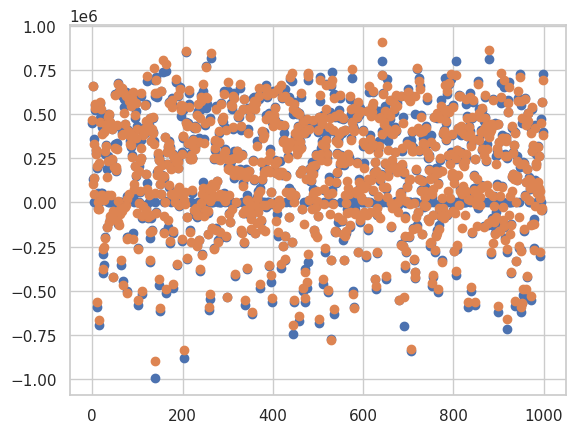

In [38]:
import matplotlib.pyplot as plt

plt.plot(y_test_true, 'o')
plt.plot(y_test_pred, 'o')
#plt.plot(abs(y_test.tolist()-y_pred))
plt.show()

In [39]:
joblib.dump(model, 'ebm_profit_big.joblib')

['ebm_profit_big.joblib']

In [ ]:
global_explanation = model.explain_global()
show(global_explanation)

In [105]:
names = local_explanation._internal_obj["specific"][0]["names"][:7]
names

['effective_price',
 'total_supplier_price_per_kg',
 'iteration_with_supplier',
 'delivery_cost_per_kg',
 'volume',
 'counterparty_reliability',
 'supplier_reliability']

In [110]:
local_explanation._internal_obj["specific"][0]["scores"][:7]

[np.float64(0.011195186458828615),
 np.float64(0.0567019726548162),
 np.float64(0.006842684672574384),
 np.float64(-0.11533400392063262),
 np.float64(-0.004077430201200331),
 np.float64(0.06341902074458453),
 np.float64(0.016611269801005482)]

In [114]:
local_explanation._internal_obj["specific"][0]["perf"]["predicted"]

np.float64(0.6285497193123809)

In [117]:
df.shape[0]

5000

## PLOTS

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [85]:
sample = X_test.iloc[:7]  # первый набор из тестовых данных
local_explanation = model.explain_local(sample)
show(local_explanation)

<!-- http://127.0.0.1:7001/140300565623040/ -->

In [25]:
#price 
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Future Price",
                  title={'text': "Product Price Prediction", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

/tmp/ipykernel_35678/1106867658.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




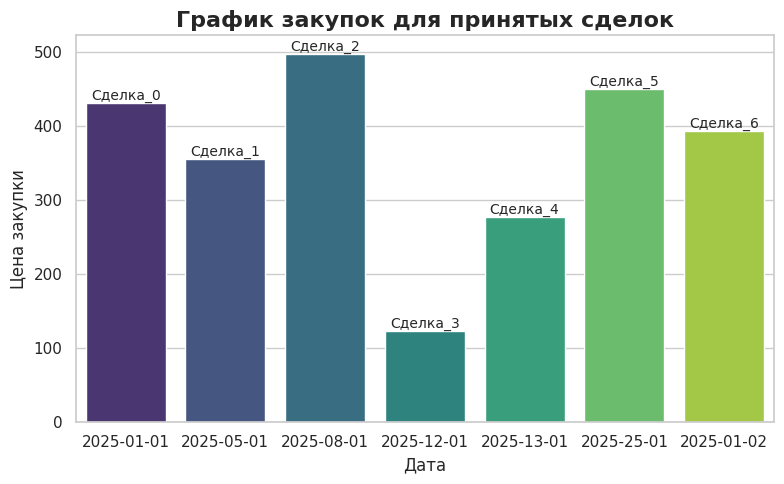

In [108]:
import random
# Example data
names = [f"Сделка_{i}" for i in np.arange(7)]
prices =  [432, 356, 498, 123, 278, 450, 394]

dates = ['2025-01-01', '2025-05-01', '2025-08-01', '2025-12-01', '2025-13-01', '2025-25-01', '2025-01-02']

# Set a beautiful style
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 5))  # Adjust the figure size for better visuals
barplot = sns.barplot(x=dates, y=prices, palette="viridis")

# Add title and labels
plt.title("График закупок для принятых сделок", fontsize=16, fontweight='bold')
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена закупки", fontsize=12)

# Annotate each bar with its value
for index, value in enumerate(names):
    plt.text(index, prices[index], value, ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_35678/3723095071.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




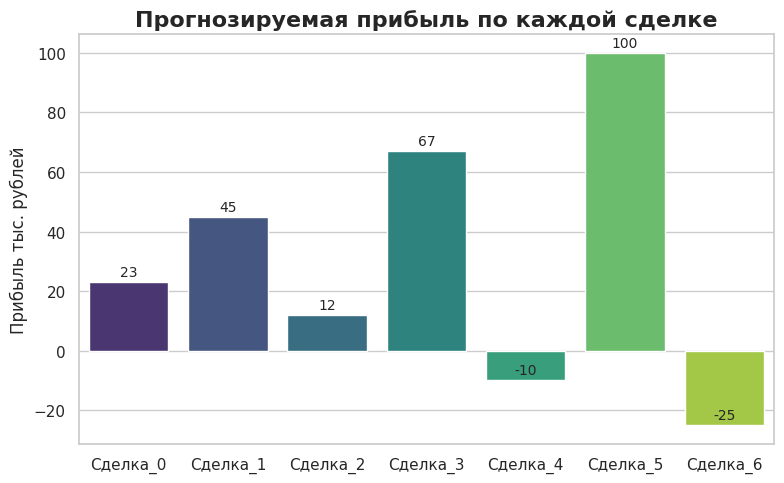

In [93]:
# Example data
names = [f"Сделка_{i}" for i in np.arange(7)]
profits = [23, 45, 12, 67, -10, 100, -25]

# Set a beautiful style
sns.set_theme(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 5))  # Adjust the figure size for better visuals
barplot = sns.barplot(x=names, y=profits, palette="viridis")

# Add title and labels
plt.title("Прогнозируемая прибыль по каждой сделке", fontsize=16, fontweight='bold')
#plt.xlabel("Сде", fontsize=12)
plt.ylabel("Прибыль тыс. рублей", fontsize=12)

# Annotate each bar with its value
for index, value in enumerate(profits):
    plt.text(index, value+1, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()